# Exercises

## 1. Unweighted Moments

Load the example image, and create a pair of 2-d (`x`, `y`) arrays (with the same shape as the image) that hold the coordinate values for every point in the data image.  The [numpy.meshgrid](http://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html) function will do almost all the work for you; you just need to figure out how to call it (after loading the image, of course).

[array([[  0,   1,   2, ..., 260, 261, 262],
       [  0,   1,   2, ..., 260, 261, 262],
       [  0,   1,   2, ..., 260, 261, 262],
       ..., 
       [  0,   1,   2, ..., 260, 261, 262],
       [  0,   1,   2, ..., 260, 261, 262],
       [  0,   1,   2, ..., 260, 261, 262]]), array([[  0,   0,   0, ...,   0,   0,   0],
       [  1,   1,   1, ...,   1,   1,   1],
       [  2,   2,   2, ...,   2,   2,   2],
       ..., 
       [264, 264, 264, ..., 264, 264, 264],
       [265, 265, 265, ..., 265, 265, 265],
       [266, 266, 266, ..., 266, 266, 266]])]


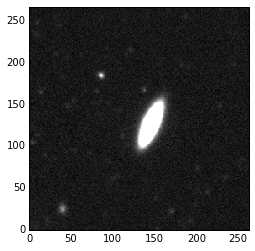

In [1]:
import IPython.display
#IPython.display.Image("../data/hsc-image-large.png")

import astropy.io.fits
import numpy

fits = astropy.io.fits.open("../../data/hsc-image-small.fits")
image = fits[0].data

from matplotlib import pyplot
%matplotlib inline
pyplot.imshow(image, origin='lower', interpolation='nearest', cmap=pyplot.cm.gray, vmin=-0.1, vmax=1.0)

def makeCoordinateArrays(shape):
    """
    Returns a meshgrid indexing coordinates given in shape.
    """
    dimensions = numpy.arange(shape[0]),numpy.arange(shape[1]) #y,x, 267 tall by 263 wide
    coord_mesh = numpy.meshgrid(dimensions[1],dimensions[0]) #x,y
    return coord_mesh

#image.shape == mesh[1].shape # Returns true
mesh = makeCoordinateArrays(image.shape)
print mesh



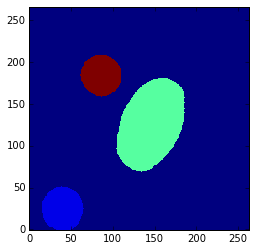

In [2]:
detections = fits[2].data
pyplot.imshow(detections, origin='lower', interpolation='nearest')

Write a function that computes the unweighted zeroth, first, and second moments of a source, given a data image, a mask image that indicates which pixels "belong" to the object, and coordinate arrays of the type you just created.

A few hints:
 - Remember that you can multiply NumPy arrays together without explicitly looping over them, returning a new NumPy array.
 - If your function returns multiple values, just separate them with commas in the return statement: "`return a, b, c`".  Or, you can group them if you like: "`return a, (b, c)`".

In [3]:
#pyplot.imshow(detections==1, origin='lower', interpolation='nearest')

def unweighted_moments(mesh,image,mask):
    """
    Computes the zeroth, first, and second moments of objects in the image
    given a mask.
    """
    x,y = mesh[0],mesh[1]
    
    # Zeroth
    m0 = numpy.sum(image[mask])

    # First
    #x*image*(detections==5).sum()
    mx = 1/m0*numpy.sum(x[mask]*image[mask])
    my = 1/m0*numpy.sum(y[mask]*image[mask])

    # Second
    mxx = 1/m0*numpy.sum((x-mx)[mask]**2*image[mask])
    myy = 1/m0*numpy.sum((y-my)[mask]**2*image[mask])
    mxy = 1/m0*numpy.sum((x-mx)[mask]*(y-my)[mask]*image[mask])
    return m0,(mx,my),(mxx,myy,mxy)
    


Call this function on all of the sources in the example image, and print the results.

In [4]:
print unweighted_moments(mesh,image,detections==1)
print unweighted_moments(mesh,image,detections==5)
print unweighted_moments(mesh,image,detections==11)

(51.959007, (37.424131496298386, 22.449075134223794), (55.327259571544836, 47.526264380787033, 19.00324807072494))
(4098.8804, (144.74723261822149, 125.75019613984021), (54.912068281109839, 157.01002276660515, 53.114210821446989))
(45.058769, (86.236133205545485, 183.30163714523115), (18.463533509241739, 63.28511041473589, 12.196595175283418))


## 2. Gaussian Weight Functions

Write a function that takes `x` and `y` arrays and first and second moments, and returns an image of an elliptical Gaussian function evaluated at those positions.  Here's the formula for a Gaussian, given those moments:

$$w(x,y) = e^{-\frac{1}{2}z^T C^{-1} z}$$

$$ z = \left[\begin{array}{ c }
     x - m_x \\
     y - m_y
   \end{array}\right]$$

$$ C = \left[\begin{array}{ c c }
     m_{xx} & m_{xy} \\
     m_{xy} & m_{yy}
   \end{array}\right]$$

Obviously, you'll need to do a little matrix algebra to code this up - you can either do that directly in Python with [numpy.matrix](http://docs.scipy.org/doc/numpy/reference/generated/numpy.matrix.html), or do some algebra yourself.

You'll note that I haven't included the standard Gaussian normalization factor - instead, normalize the result to make sure it sums to one before you return it.

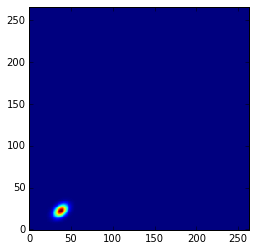

In [6]:
def gaussianWeight(moments):
    m0,(mx,my),(mxx,myy,mxy) = moments

    C = [[mxx,mxy],[mxy,myy]]
    Cinv = numpy.linalg.inv(C)

    x,y = mesh[0],mesh[1]
    matrix_product = (x-mx)**2*Cinv[0,0] + (y-my)**2*Cinv[1,1] + 2*(x-mx)*(y-my)*Cinv[0,1]

    gaussian = numpy.exp(-1/2*matrix_product)
    #gaussian = numpy.exp(-1./10000*(mesh[0]**2+mesh[1]**2)) # test gaussian of sigma 100
    gaussian /= gaussian.sum()
    #pyplot.imshow(gaussian, origin='lower', interpolation='nearest',)
    return gaussian

moments = unweighted_moments(mesh,image,detections==1)
weight = gaussianWeight(moments)
pyplot.imshow(weight, origin='lower', interpolation='nearest',)

## 3. Weighted Moments

Modify your moments function so it takes a weight image instead of a mask image.  Make sure it still works if the weight image is just a mask image (even if it's less efficient) - a mask image is, after all, just a special case of a weight image.

In [8]:
def weighted_moments(mesh,image,weight):
    """
    Computes the zeroth, first, and second moments of objects in the image
    given a weight image.
    """
    x,y = mesh[0],mesh[1]
    
    # Zeroth
    m0 = numpy.sum(image*weight)

    # First
    #x*image*(detections==5).sum()
    mx = 1/m0*numpy.sum(x*image*weight)
    my = 1/m0*numpy.sum(y*image*weight)

    # Second
    mxx = 1/m0*numpy.sum((x-mx)**2*image*weight)
    myy = 1/m0*numpy.sum((y-my)**2*image*weight)
    mxy = 1/m0*numpy.sum((x-mx)*(y-my)*image*weight)
    return m0,(mx,my),(mxx,myy,mxy)

Run this function the same way you ran Exercise 1 on the largest source in the image, using the mask image as the weight image.

In [9]:
print weighted_moments(mesh,image,detections==1)

(51.959007, (37.424131496298386, 22.449075134223794), (55.327259571544836, 47.526264380787026, 19.00324807072494))


Use the moments you just computed and the function from Exercise 2 to create a Gaussian weight image.

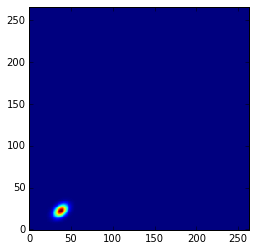

In [13]:
moments = weighted_moments(mesh,image,detections==1)
weight = gaussianWeight(moments)
pyplot.imshow(weight, origin='lower', interpolation='nearest',)

Run this function on the example data image again, but this time use the Gaussian image as the weights.

In [14]:
print weighted_moments(mesh,image,weight)

(0.15405506652760922, (38.934302876255401, 23.828380620169529), (8.5924731253026376, 10.170572172390019, 2.2555252546478419))


## 4. Biased Measurements

Run the weighted moments function using the Gaussian image as *both* the data image and the weight image - let's see if you get back the same moments you used to create the Gaussian image.

Surprise!  You don't.  Repeat this a few times, using different moments to create the original Gaussian image.  Can you identify a relationship between the moments you get out, and the moments you put in?  (Hint: it'll involve a nice, round integer number you might have to round off to).

Adjust your weighted moments function to include the calibration factor you've found.

If you're curious, you can work out this correction algebraically if you replace the sums with integrals, and plug the Gaussian in as both the image and the weight function.